<a href="https://colab.research.google.com/github/Abhishek1t/Brain_tumor/blob/gan/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!chmod 777 /content/kaggle.json #change permissions
!mkdir /root/.kaggle #create root folder

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!mv /content/kaggle.json /root/.kaggle

In [ ]:
!kaggle datasets download ifigotin/imagenetmini-1000 #image download

100% 3.92G/3.92G [00:46<00:00, 48.6MB/s]
100% 3.92G/3.92G [00:46<00:00, 90.2MB/s]


In [ ]:
!mkdir /CGAN/
!mkdir /CGAN/Data
!unzip /content/imagenetmini-1000.zip -d /CGAN
!mkdir /images
!mv /CGAN/Data /images/

Streaming output truncated to the last 5000 lines.
  inflating: /CGAN/imagenet-mini/train/n07875152/n07875152_2763.JPEG  
  inflating: /CGAN/imagenet-mini/train/n07875152/n07875152_3015.JPEG  
  inflating: /CGAN/imagenet-mini/train/n07875152/n07875152_3378.JPEG  
  inflating: /CGAN/imagenet-mini/train/n07875152/n07875152_3497.JPEG  
  inflating: /CGAN/imagenet-mini/train/n07875152/n07875152_3745.JPEG  
  inflating: /CGAN/imagenet-mini/train/n07875152/n07875152_4157.JPEG  
  inflating: /CGAN/imagenet-mini/train/n07875152/n07875152_461.JPEG  
  inflating: /CGAN/imagenet-mini/train/n07875152/n07875152_4704.JPEG  
  inflating: /CGAN/imagenet-mini/train/n07875152/n07875152_4789.JPEG  
  inflating: /CGAN/imagenet-mini/train/n07875152/n07875152_4848.JPEG  
  inflating: /CGAN/imagenet-mini/train/n07875152/n07875152_4940.JPEG  
  inflating: /CGAN/imagenet-mini/train/n07875152/n07875152_546.JPEG  
  inflating: /CGAN/imagenet-mini/train/n07875152/n07875152_5607.JPEG  
  inflating: /CGAN/imagenet-

In [ ]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
import pandas as pd

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

In [ ]:
device

device(type='cuda')

In [ ]:
import fastai
fastai.__version__

'2.7.13'

In [ ]:
!mkdir /CGAN/imagenet-mini/train2

In [ ]:

# importing required packages
from pathlib import Path
import shutil
import os

# path to source directory



from glob import glob
dir=glob("/CGAN/imagenet-mini/train/*/", recursive = True)

#src_dir = '/CGAN/imagenet-mini/train/n01440764'

# path to destination directory
for f in dir:
  src_dir=f
  dest_dir = '/CGAN/imagenet-mini/train2'


  files=os.listdir(src_dir)

  # iterating over all the files in
  # the source directory
  for fname in files:

    # copying the files to the
    # destination directory
    shutil.copy2(os.path.join(src_dir,fname), dest_dir)


In [ ]:
#path = "/CGAN/imagenet-mini"
path = '/CGAN/imagenet-mini/train2'

import glob
import numpy as np

paths = glob.glob(path + "/*.JPEG") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 5000, replace = True) # choosing 1000 images randomly
rand_idxs = np.random.permutation(5000)
train_idxs = rand_idxs[:4000] # choosing the first 4000 as training set
val_idxs = rand_idxs[4000:] # choosing last 1000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

4000 1000


In [ ]:
import glob
import numpy as np

# Your path to the image directory
path = "/CGAN/imagenet-mini/train2"

# Grabbing all the image file names
paths = glob.glob(path + "/*.JPEG")

# Checking the length of paths to avoid sampling more items than available
total_paths = len(paths)

# Choosing the number of images to sample (adjust as needed)
num_images_to_sample = 1000

if total_paths >= num_images_to_sample:
    np.random.seed(123)
    paths_subset = np.random.choice(paths, num_images_to_sample, replace=False)  # Sample without replacement
    rand_idxs = np.random.permutation(num_images_to_sample)
    train_idxs = rand_idxs[:800]  # Choosing the first 800 as the training set
    val_idxs = rand_idxs[800:]   # Choosing the last 200 as the validation set
    train_paths = paths_subset[train_idxs]
    val_paths = paths_subset[val_idxs]
    print(len(train_paths), len(val_paths))
else:
    print("Not enough paths available to sample the specified number of images.")
    print("Total paths available:", total_paths)


800 200


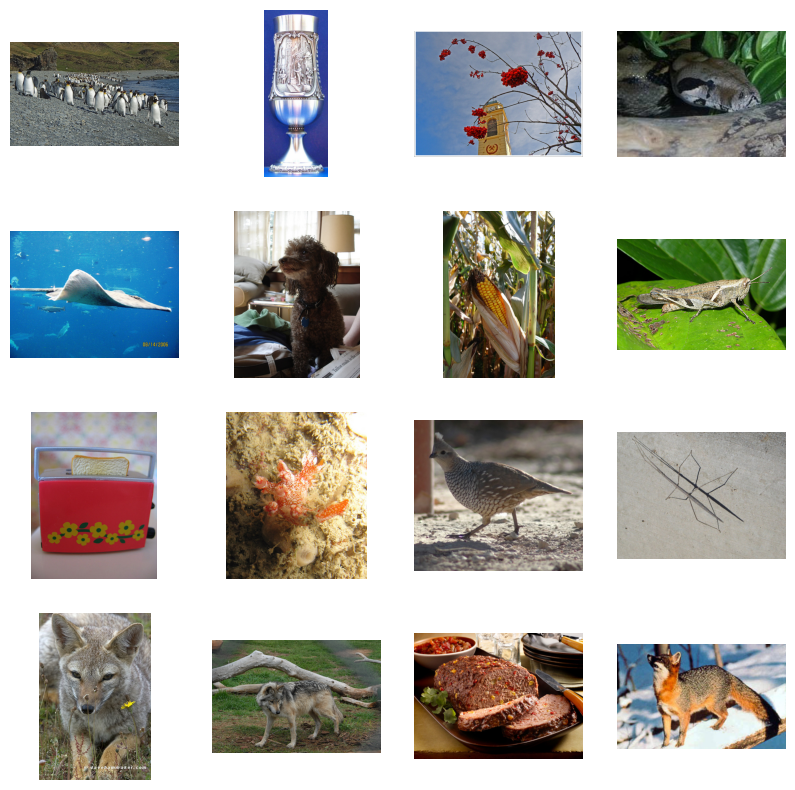

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [ ]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=0, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [ ]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
50 13


In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [ ]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [ ]:
#####################################################################

In [ ]:
# Generator for colorization
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Define the layers for feature extraction and image generation
        self.encoder = nn.Sequential(
            # Convolutional layers for feature extraction
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # More convolutional layers
            # ...
        )
        self.decoder = nn.Sequential(
            # Transposed convolutional layers for image generation
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Output layer with tanh activation
        )

    def forward(self, x):
        # Feature extraction in the encoder
        features = self.encoder(x)
        # Image generation in the decoder
        output = self.decoder(features)
        return output

# Discriminator for distinguishing real vs. fake images
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Define the layers for feature extraction and classification
        self.conv_layers = nn.Sequential(
            # Convolutional layers for feature extraction
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            # More convolutional layers
            # ...
        )
        self.fc_layers = nn.Sequential(
            # Fully connected layers for classification
            nn.Linear(64 * 256 * 256, 1),  # Example linear layer
            nn.Sigmoid()  # Output layer with sigmoid activation
        )

    def forward(self, x):
        # Feature extraction in convolutional layers
        features = self.conv_layers(x)
        # Flatten features for fully connected layers
        features = torch.flatten(features, 1)
        # Classification in fully connected layers
        output = self.fc_layers(features)
        return output


In [ ]:

def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict,show=True):
    res = {}
    for loss_name, loss_meter in loss_meter_dict.items():
        if show:
          print(f"{loss_name}: {loss_meter.avg:.5f}")
        res[loss_name] = loss_meter.avg

    return res

In [ ]:
results = []
show=False
def train_model(model, train_dl, epochs, display_every=1):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        print(e)
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i in [1,5,10,50,100,249]:
                visualize(model, data, save=False) # function displaying the model's outputs
                show=True
            else:
                show=False
            if show:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
            results.append(log_results(loss_meter_dict,show=show)) # function to print out the losses


model = MainModel()
train_model(model, train_dl, 45)

In [ ]:
!mkdir /CGAN/imagenet-mini/train2_model

In [ ]:
!mkdir /CGAN/imagenet-mini/model

In [ ]:
!mkdir /CGAN/imagenet-mini/model/raw_data

In [ ]:
import pandas as pd
torch.save(model, '/CGAN/imagenet-mini/model.pt')
df=pd.DataFrame(results)
df.to_csv('/CGAN/imagenet-mini/model/raw_data.csv')

In [ ]:
map_location=torch.device('cuda')
model = torch.load('/CGAN/imagenet-mini/model.pt')
model.eval()

MainModel(
  (net_G): Unet(
    (model): UnetBlock(
      (model): Sequential(
        (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): UnetBlock(
          (model): Sequential(
            (0): LeakyReLU(negative_slope=0.2, inplace=True)
            (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
            (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): UnetBlock(
              (model): Sequential(
                (0): LeakyReLU(negative_slope=0.2, inplace=True)
                (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (3): UnetBlock(
                  (model): Sequential(
                    (0): LeakyReLU(negative_slope=0.2, inplace=True)
                    (1): Conv2d(256, 512, kernel_s

In [ ]:
!mkdir /CGAN/imagenet-mini/train2_model/model_45epoch

In [ ]:
import pandas as pd
torch.save(model, '/CGAN/imagenet-mini/train2_model/model_epoch.pt')
df=pd.DataFrame(results)
df.to_csv('/CGAN/imagenet-mini/train2.csv')

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
drive_path = '/content/gdrive/My Drive/'
os.makedirs(drive_path, exist_ok=True)
os.chdir(drive_path)

In [ ]:
torch.save(model.state_dict(), 'my_model.pth')

In [ ]:
map_location=torch.device('cuda')
model45= torch.load('/CGAN/imagenet-mini/train2_model/model_45epoch.pt')

In [ ]:
df = pd.read_csv('/CGAN/imagenet-mini/train2.csv')

In [ ]:
df

Unnamed: 0  loss_D_fake  loss_D_real    loss_D  loss_G_GAN  loss_G_L1  \
0              0     0.832185     0.828224  0.830204    1.756255  20.725897   
1              1     1.318696     1.332735  1.325715    1.504872  18.736453   
2              2     1.242948     1.279864  1.261406    1.284862  17.499494   
3              3     1.124747     1.167853  1.146300    1.168255  17.126122   
4              4     1.051362     1.092157  1.071760    1.101522  16.288645   
...          ...          ...          ...       ...         ...        ...   
2245        2245     0.567098     0.588523  0.577810    1.100176   7.093943   
2246        2246     0.563331     0.584117  0.573724    1.101156   7.101130   
2247        2247     0.562526     0.584101  0.573314    1.097180   7.103097   
2248        2248     0.561404     0.589624  0.575514    1.090474   7.080179   
2249        2249     0.571062     0.583165  0.577114    1.087765   7.088093   

         loss_G  
0     22.482151  
1     20.241324  
2     18.784356  
3     18.294376  
4     17.390166  
...         ...  
2245   8.194119  
2246   8.202286  
2247   8.200277  
2248   8.170653  
2249   8.175858  

[2250 rows x 7 columns]

In [ ]:
df.columns

Index(['Unnamed: 0', 'loss_D_fake', 'loss_D_real', 'loss_D', 'loss_G_GAN',
       'loss_G_L1', 'loss_G'],
      dtype='object')

Text(0.5, 0, 'Iteration')

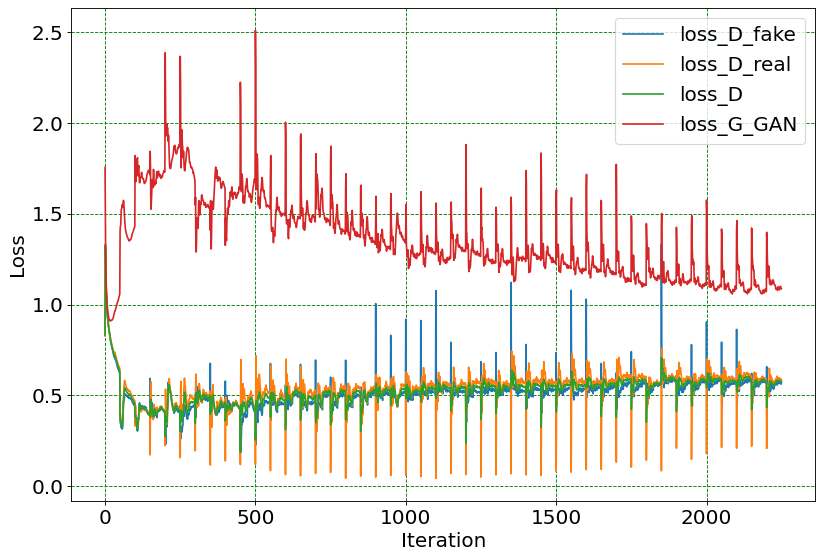

In [ ]:
#all
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12, 8), dpi=80)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.8)
for i in df.columns[1:5]:
  plt.plot(np.arange(len(df[i])),df[i],label=i)
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Iteration')

In [ ]:
plt.rcParams.update({'font.size': 18})

Text(0.5, 0, 'Iteration')

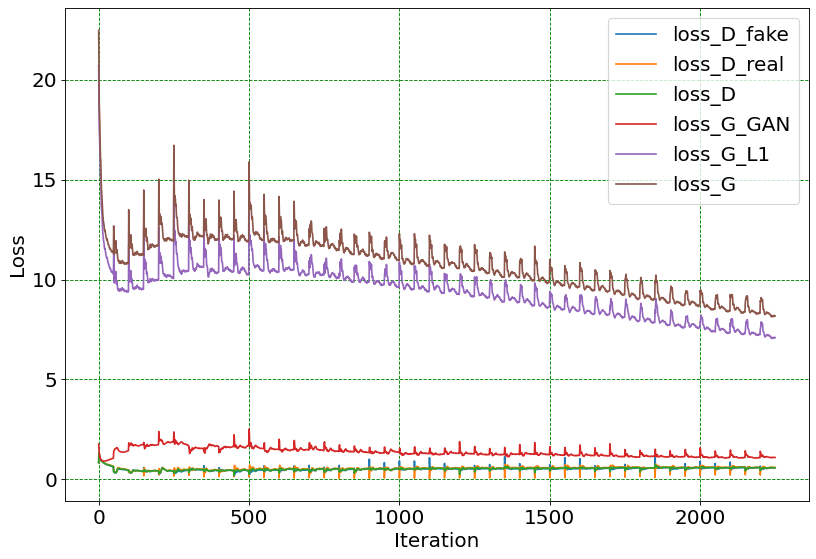

In [ ]:
#all
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12, 8), dpi=80)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.8)
for i in df.columns[1:]:
  plt.plot(np.arange(len(df[i])),df[i],label=i)
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

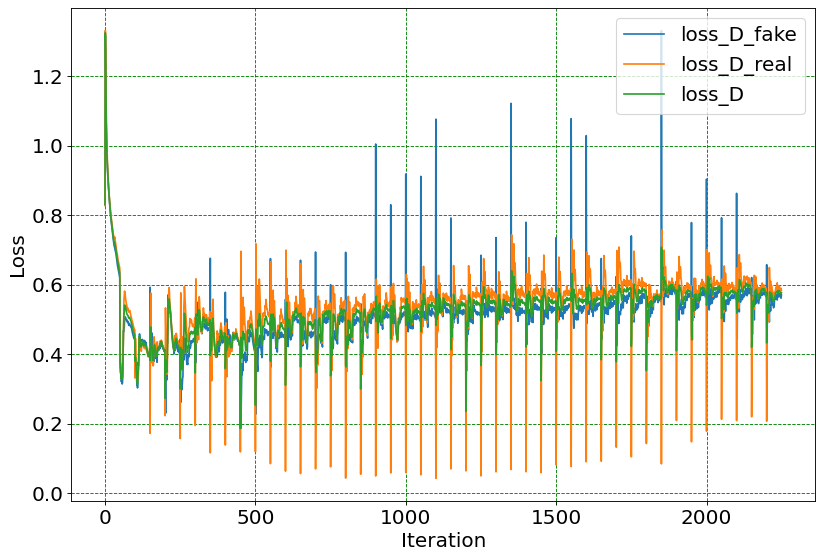

In [ ]:
#Loss D
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12, 8), dpi=80)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.8)
for i in df.columns[1:4]:
  plt.plot(np.arange(len(df[i])),df[i],label=i)
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

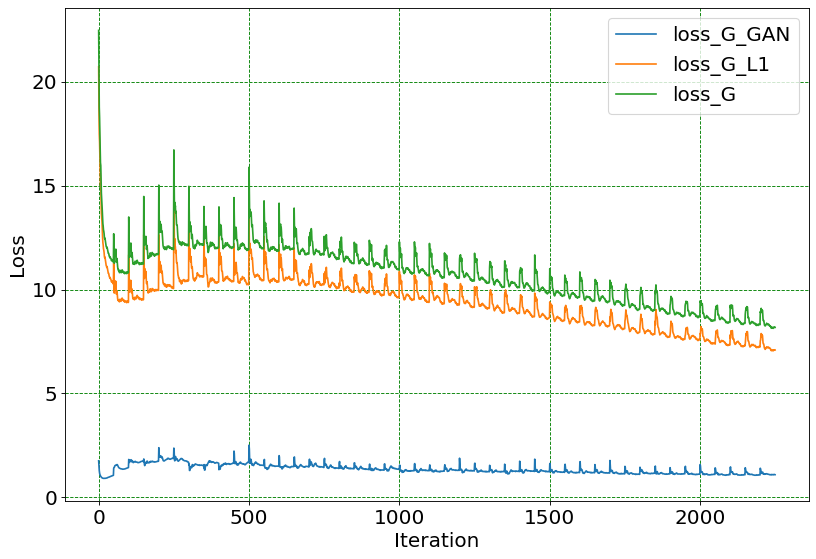

In [ ]:
#Loss G
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12, 8), dpi=80)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.8)
for i in df.columns[4:]:
  plt.plot(np.arange(len(df[i])),df[i],label=i)
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

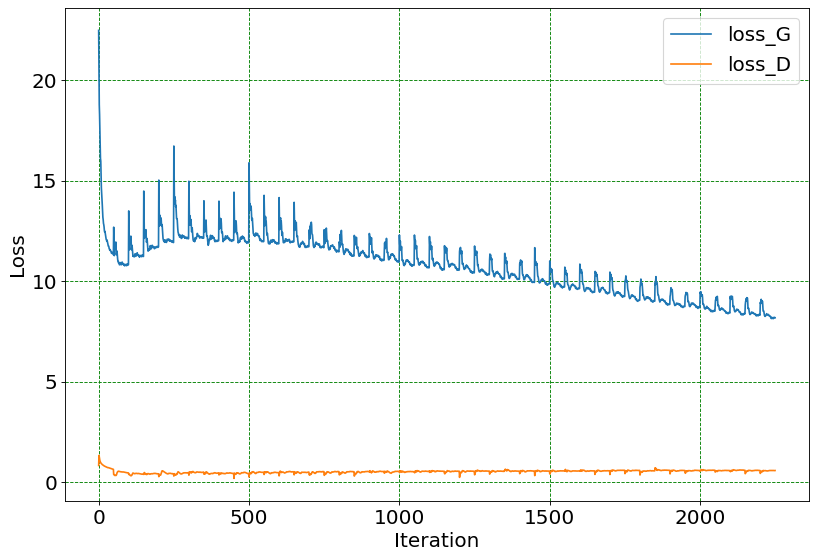

In [ ]:
#Loss D , G
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12, 8), dpi=80)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.8)
plt.plot(np.arange(len(df['loss_G'])),df['loss_G'],label='loss_G')
plt.plot(np.arange(len(df['loss_D'])),df['loss_D'],label='loss_D')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Iteration')

In [ ]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

if use_colab == True:
    path = coco_path
else:
    path = "Your path to the dataset"

paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset_coco = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly


In [ ]:
map_location=torch.device('cuda')
model45= torch.load('/CGAN/imagenet-mini/train2_model/model_45epoch.pt',map_location)

In [ ]:
############################################################################

625


  0%|          | 0/625 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 35 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return func(*args, **kwargs)


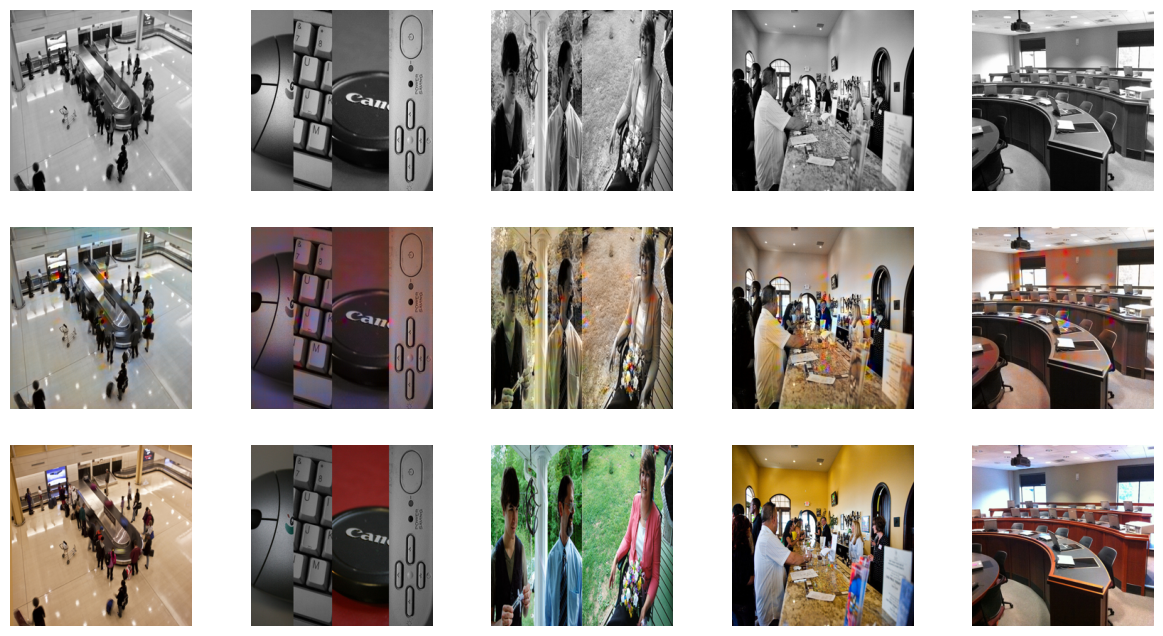

In [ ]:
test_coco = make_dataloaders(paths=paths_subset_coco, split='val')
print(len(test_coco))
for data in tqdm(test_coco):
  visualize(model45,data , save=False)
  break

In [ ]:
####################################################

In [ ]:
#!pip install fastai==2.4
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [ ]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [ ]:
class ResUnet(nn.Module):
    def __init__(self, n_input, n_output, size):
        super().__init__()
        # define the layers of the model here
        # for example, you could use the fastai function res_block
        self.layers = nn.Sequential(
            res_block(n_input),
            res_block(n_input, size//2),
            res_block(n_input, size//4),
            res_block(n_input, size//8),
            res_block(n_input, size//16),
            res_block(n_input, size//32),
            res_block(n_input, size//64),
            nn.Conv2d(n_input, n_output, kernel_size=1)
        )

    def forward(self, x):
        # define the forward pass of the model here
        # for example, you could apply the layers sequentially
        return self.layers(x)

def build_res_unet(n_input, n_output, size):
    # return an instance of the ResUnet class
    return ResUnet(n_input, n_output, size)


In [ ]:
!mkdir /CGAN/imagenet-mini/train2_model/res18-unet

In [ ]:
!pip install fastai --upgrade


In [ ]:
from fastai.vision.learner import res_block

ImportError: ignored

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(net_G, train_dl, opt, criterion, 20)
torch.save(net_G.state_dict(), "/CGAN/imagenet-mini/train2_model/res18-unet.pt")

In [ ]:
hell= torch.load('/CGAN/imagenet-mini/train2_model/model_epoch.pt')

In [ ]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

if use_colab == True:
    path = coco_path
else:
    path = "Your path to the dataset"

paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset_coco = np.random.choice(paths, 10, replace=False) # choosing 1000 images randomly

In [ ]:
paths_subset_coco

array(['/root/.fastai/data/coco_sample/train_sample/000000020251.jpg',
       '/root/.fastai/data/coco_sample/train_sample/000000028978.jpg',
       '/root/.fastai/data/coco_sample/train_sample/000000183495.jpg',
       '/root/.fastai/data/coco_sample/train_sample/000000406073.jpg',
       '/root/.fastai/data/coco_sample/train_sample/000000041550.jpg',
       '/root/.fastai/data/coco_sample/train_sample/000000313341.jpg',
       '/root/.fastai/data/coco_sample/train_sample/000000157260.jpg',
       '/root/.fastai/data/coco_sample/train_sample/000000039203.jpg',
       '/root/.fastai/data/coco_sample/train_sample/000000366104.jpg',
       '/root/.fastai/data/coco_sample/train_sample/000000532126.jpg'],
      dtype='<U60')

1


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return func(*args, **kwargs)


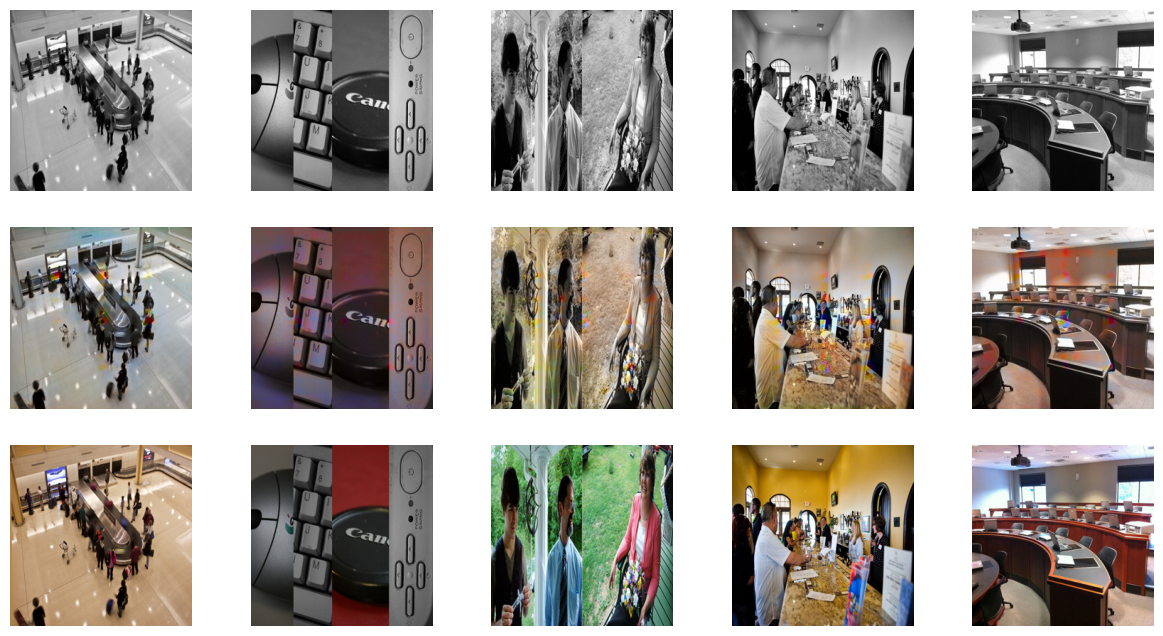

In [ ]:
test_coco = make_dataloaders(paths=paths_subset_coco, split='val')
print(len(test_coco))
for data in tqdm(test_coco):
  visualize(hell,data , save=False)
  break

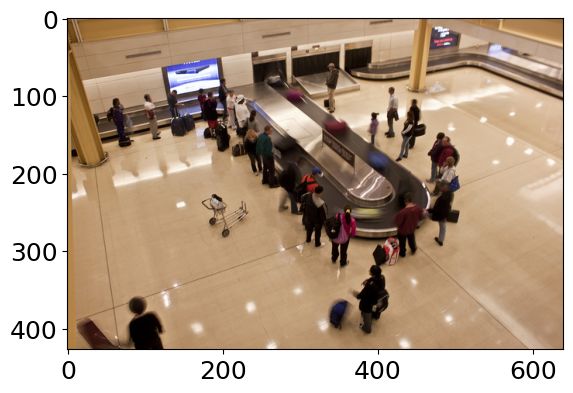

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread('/root/.fastai/data/coco_sample/train_sample/000000020251.jpg')
plt.imshow(img)